# Testing Pmf.py code with ideal diode fitting

Some stuff for testing out `ID_pmf.py` (which inherits from `Pmf.py` and defines a PMF over ideality factor and $J_0$ in the ideal diode equation) and `ID_bayes.py` which defines relevant likelihood function.

Also working on visualizing, at least in 2D. General-dimension stuff for that to come later.

In [21]:
import numpy as np
import ID_bayes as bayes
import ID_pmf as pmf

## Initialize some stuff (create the "measurements")

Our "measurements" will be on a diode with $n=1.5$ and $J_0=5$. We'll start with five subdivisions in $n$ (linearly spaced between 1 and 2) and four in $J_0$ (logarithmically spaced between 0.1 and 100). "Measurements" at three temperatures and from -0.1 V to 0.2 V.

In [54]:
test = pmf.ID_Pmf([10,10])
voltages = np.arange(-0.1, 0.2, 0.05)
currents_100 = [test.compute_ID(V,100,{'n':1.5,'J_0':5}) for V in voltages]
currents_300 = [test.compute_ID(V,300,{'n':1.5,'J_0':5}) for V in voltages]
currents_500 = [test.compute_ID(V,500,{'n':1.5,'J_0':5}) for V in voltages]

In [55]:
test.probs

array([[ 0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,
         0.01],
       [ 0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,
         0.01],
       [ 0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,
         0.01],
       [ 0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,
         0.01],
       [ 0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,
         0.01],
       [ 0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,
         0.01],
       [ 0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,
         0.01],
       [ 0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,
         0.01],
       [ 0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,
         0.01],
       [ 0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,
         0.01]])

## First Bayes

Let's feed in the measurement at 300 K and 0.1 V.

In [24]:
voltages[4],currents_300[4]

(0.10000000000000001, 60.91850555901982)

Gotta love machine error. Anyway, we'll call the uncertainty 5. In whatever units these hypothetical currents are.

In [56]:
lkl=bayes.likelihood(test, currents_300[4], voltages[4], 300, 5)

Now, we could just look at the numbers for the probabilities...

In [26]:
lkl.probs

array([[  3.71046561e-025,   3.24922107e-003,   4.73605477e-295,
          0.00000000e+000],
       [  2.45745511e-028,   6.29874851e-012,   2.96423450e-054,
          0.00000000e+000],
       [  7.51229816e-030,   6.19063620e-018,   1.18297116e-008,
          0.00000000e+000],
       [  1.10963002e-030,   1.09005053e-021,   8.76914891e-001,
          0.00000000e+000],
       [  3.47111378e-031,   4.02308313e-024,   1.19835876e-001,
          0.00000000e+000]])

But that's going to get cumbersome fast as the matrices get bigger, so it'd be nice to visualize.

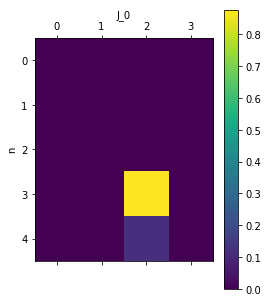

In [27]:
from matplotlib import pyplot as plt
%matplotlib inline

def visualize_probs(pmf):
    plt.matshow(pmf.probs)
    # get and round off values along J_0 and label that axis
    # this way to cleverly get indices doesn't actually work - to figure out later
    #xlocs, xlabels = plt.xticks()
    #xinds = [int(xlabel.get_text()) for xlabel in xlabels[1:-1]]
    #plt.gca().set_xticklabels(['']+list([round(bc,1) for bc in pmf.box_centers()['J_0'][xinds]]))
    plt.xlabel('J_0')
    plt.gca().xaxis.set_label_position('top')
    # get n values and label that axis
    #plt.gca().set_yticklabels(['']+list(pmf.box_centers()['n']))
    plt.ylabel('n')
    plt.colorbar()
    plt.show()
    
visualize_probs(lkl)

## Onward!

Okay, now let's keep going! We'll do some Bayesian updating and subdivisions "by hand" and visualize the PMF at each step along the way.

In [57]:
test.multiply(lkl)

That's the update (note that the `multiply` function also renormalizes the PMF afterwards)! Now let's subdivide all cells with a probability higher thatn 0.1.

In [29]:
test.subdivide(0.1)

We can check the levels of subdivision at each point:

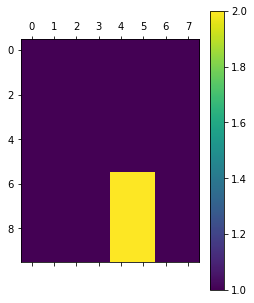

In [30]:
plt.matshow(test._m)
plt.colorbar()
plt.show()

Check the distribution still looks the same after the subdivision:

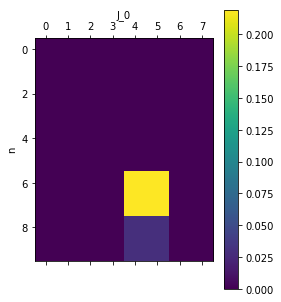

In [31]:
visualize_probs(test)

Cool. So now we'll feed in some data at 100 K and see what happens.

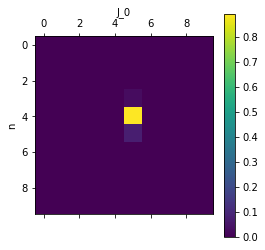

In [58]:
lkl=bayes.likelihood(test, currents_100[0], voltages[0], 100, 0.5)
test.multiply(lkl)
visualize_probs(test)

In [17]:
test.box_centers()['n'][6], test.box_centers()['J_0'][4]

(1.6499999999999999, 4.8696752516586308)

In [59]:
test.most_probable(2)

[{'J_0': 4.46683592150963, 'n': 1.55, 'prob': 0.074258269928999296},
 {'J_0': 4.46683592150963, 'n': 1.45, 'prob': 0.89455144809834497}]

Moar observations plz!

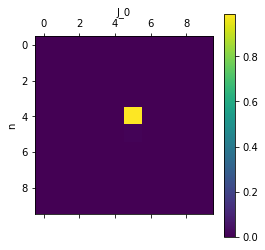

In [60]:
lkl=bayes.likelihood(test, currents_500[6], voltages[6], 500, 10)
test.multiply(lkl)
visualize_probs(test)

In [61]:
test.subdivide(0.1)

In [41]:
currents_100, currents_300, currents_500

([-4.997817983860017,
  -4.895548668271211,
  0.0,
  234.34591915891676,
  11452.293803605324,
  548446.3032995338,
  26253911.260426637],
 [-4.620743829248125,
  -3.6229448617577535,
  0.0,
  13.154683357059668,
  60.91850555901982,
  234.34591915891622,
  864.0498750269062],
 [-3.9359853804509184,
  -2.6934716351743235,
  0.0,
  5.838800155787142,
  18.49591776341827,
  45.93351142289994,
  105.41163030906289])

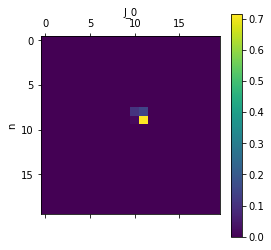

In [62]:
lkl=bayes.likelihood(test, currents_300[3], voltages[3], 300, 1)
test.multiply(lkl)
visualize_probs(test)

In [63]:
test.most_probable(3)

[{'J_0': 3.7583740428844412, 'n': 1.425, 'prob': 0.10735390256134743},
 {'J_0': 5.3088444423098817, 'n': 1.425, 'prob': 0.147545746798383},
 {'J_0': 5.3088444423098817,
  'n': 1.4750000000000001,
  'prob': 0.71581044722943266}]